<a href="https://github.com/ml-for-high-risk-apps-book/Machine-Learning-for-High-Risk-Applications-Book/blob/main/code/Chapter-7/6.Label_Randomization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 7: Explaining a PyTorch Image Classifier

## <font color=green>**6.Label Randomization.**</font>

In this section, we reproduce (in part) the damning unfaithfulness results from [Sanity checks for saliency maps](https://arxiv.org/abs/1810.03292). In that paper, the authors were interested in the question: "are the outputs generated by these post-hoc explanation methods actually telling us anything about the model?" As we’ll see in this experiment, sometimes the result is an emphatic no.

To begin our experiment, we train a nonsense model where images have random labels. In Model performance during training on data where the labels have been randomly shuffled., we can see the high training loss and poor accuracy curves for a new model that has been trained on a dataset where the image labels have been randomly shuffled. 

## Setting the Environment

If you are using Colab, it comes preinstalled with PyTorch and other commonly used libraries for machine and Deep learning. If you are executing this notebook in your local system, you will need to install them manually via the following commands:

In [ ]:
#!pip3 install torch torchvision numpy pandas matplotlib seaborn scikit-learn captum --quiet 

In [1]:
#Importing the necessary libraries

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random


import copy
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, classification_report


import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid, save_image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image

from sklearn.metrics import confusion_matrix

# Seed
seed = 123
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
random_seed = 12345

In [3]:
# Defining seed_worker function for reproducible experiments
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

## Importing the Data

Load the preprocessed data mentioned in the [`Data Preparation`](https://github.com/ml-for-high-risk-apps-book/Machine-Learning-for-High-Risk-Applications-Book/blob/main/code/Chapter-7/1.Data%20Preparation.ipynb) notebook. 


In [4]:
PATH = 'chest_xray_pre-processed'

## Creating Training & Validation Dataloaders


In [5]:
train_ds = ImageFolder(PATH+'/train', 
                        transform = transforms.Compose([transforms.Resize((224,224)),
                                            transforms.RandomRotation(10),
                                            transforms.RandomGrayscale(),
                                            transforms.RandomAffine(translate=(0.05,0.05), degrees=0),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                           ]))
val_ds = ImageFolder(PATH+'/val', 
                        transform = transforms.Compose([transforms.Resize((224,224)),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                           ]))

len(train_ds), len(val_ds)

(4255, 977)

In [6]:
data_train = train_ds.samples
data_valid = val_ds.samples

In [7]:
with open("data_train.csv", "w") as f:
    csv_writer = csv.writer(f)
    for train_tuple in data_train:
        csv_writer.writerow(train_tuple)
        
with open("data_valid.csv", "w") as f:
    csv_writer = csv.writer(f)
    for val_tuple in data_valid:
        csv_writer.writerow(val_tuple) 

In [8]:
df_train = pd.read_csv('data_train.csv', header=None, names=['image_path','label'])
df_val = pd.read_csv('data_valid.csv', header=None, names=['image_path','label'])

## Permuting the label column

In [9]:
# Permuting the column in Training set
df_train['label'] = np.random.permutation(df_train['label'].values)
df_train.head()

,image_path,label
0,chest_xray_pre-processed/chest_xray/train/NORM...,1
1,chest_xray_pre-processed/chest_xray/train/NORM...,1
2,chest_xray_pre-processed/chest_xray/train/NORM...,1
3,chest_xray_pre-processed/chest_xray/train/NORM...,0
4,chest_xray_pre-processed/chest_xray/train/NORM...,1


In [10]:
# Permuting the column in Validation set
df_val['label'] = np.random.permutation(df_val['label'].values)
df_val.head()


,image_path,label
0,chest_xray_pre-processed/chest_xray/val/NORMAL...,0
1,chest_xray_pre-processed/chest_xray/val/NORMAL...,0
2,chest_xray_pre-processed/chest_xray/val/NORMAL...,1
3,chest_xray_pre-processed/chest_xray/val/NORMAL...,0
4,chest_xray_pre-processed/chest_xray/val/NORMAL...,0


In [11]:
data_dir = "/content/chest_xray/chest_xray"
train_images = df_train.image_path.tolist()
train_targets = df_train.label.values


valid_images = df_val.image_path.tolist()
valid_targets = df_val.label.values

In [12]:
class CustomDataset:

    def __init__(self,image_paths,targets,resize = None, transforms=None):
    
            self.image_paths = image_paths
            self.targets = targets
            self.resize = resize
            self.transforms = transforms
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, item):

        image = Image.open(self.image_paths[item])
        image = image.convert("RGB")
        targets = self.targets[item]
        
        if self.resize:
            image = image.resize( 
                (self.resize[1], self.resize[0]),
                resample=Image.BILINEAR
            )
         
        image = np.array(image)
        
        if self.transforms:
            image = self.transforms(image)    
            
       

        # pytorch expects CHW instead of HWC
        #image = np.transpose(image, (2, 0, 1)).astype(np.float32)

        sample = (image, targets)
        return sample

In [13]:
mean, std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(10),
    transforms.RandomGrayscale(),
    transforms.RandomAffine(translate=(0.05,0.05),degrees=0),
    transforms.Normalize(mean, std)])

In [14]:
train_dataset = CustomDataset(image_paths=train_images,
                                                targets=train_targets,
                                                resize=(224,224),
                                                transforms=transform)
train_size = len(train_dataset)

valid_dataset = CustomDataset(image_paths=valid_images,
                                                targets=valid_targets,
                                                resize=(224,224),
                                                transforms=transform)
valid_size = len(valid_dataset)


In [15]:
batch_size=16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                          num_workers=3)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size,
                                            num_workers=3)

In [16]:

loaders = {'train':train_loader, 'val':valid_loader}
dataset_sizes = {'train':len(train_dataset), 'val':len(valid_dataset)}

In [17]:
classes = dict({0: 'Normal',
               1: 'Pneumonia'})

## Import the Previously trained Model

In [20]:
class CustomDenseNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = model.model

        for param in self.model.parameters():
            param.requires_grad = False
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(in_features, CONFIG['num_classes'])
    def forward(self, x):
        x = self.model(x)
        return x

In [20]:

model = torch.load('Finetuning_Stage2.pt')
model.to(device);

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.1)

In [25]:
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}


def train(model, criterion, optimizer, scheduler, epochs):
  since = time.time()
  best_model = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  for epoch in range(epochs):
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0.0

      for inputs, labels in loaders[phase]:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase=='train'):
          outp = model(inputs)
          _, pred = torch.max(outp, 1)
          loss = criterion(outp, labels)
          loss.requires_grad = True
          
        
          if phase == 'train':
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item()*inputs.size(0)
        running_corrects += torch.sum(pred == labels.data)


      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double()/dataset_sizes[phase]
      losses[phase].append(epoch_loss)
      accuracies[phase].append(epoch_acc)
      if phase == 'train':
        print('Epoch: {}/{}'.format(epoch+1, epochs))
      print('{} - loss:{}, accuracy{}'.format(phase, epoch_loss, epoch_acc))
    
      if phase == 'val':
        print('Time: {}m {}s'.format((time.time()- since)//60, (time.time()- since)%60))
            
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model = copy.deepcopy(model.state_dict())
    scheduler.step()  
  time_elapsed = time.time() - since
  print('Training Time {}m {}s'.format(time_elapsed//60, time_elapsed%60)) 
  print('Best accuracy {}'.format(best_acc))

  model.load_state_dict(best_model)
  return model   

In [26]:

epochs = 15

In [27]:
model = train(model, criterion, optimizer, scheduler, epochs)

Epoch: 1/15
train - loss:3.651533299467398, accuracy0.6258519388954171
val - loss:5.355059668974628, accuracy0.5138178096212896
Time: 0.0m 28.558393955230713s
Epoch: 2/15
train - loss:3.679030021573346, accuracy0.6277320799059929
val - loss:5.395198011061867, accuracy0.5158648925281474
Time: 0.0m 58.326112508773804s
Epoch: 3/15
train - loss:3.652494716420157, accuracy0.6291421856639248
val - loss:5.526860537013171, accuracy0.5117707267144319
Time: 1.0m 27.07973313331604s
Epoch: 4/15
train - loss:3.6544560793844147, accuracy0.6296122209165688
val - loss:5.740546140076255, accuracy0.5138178096212896
Time: 1.0m 55.60902690887451s
Epoch: 5/15
train - loss:3.655191758264526, accuracy0.6235017626321974
val - loss:5.208920518780926, accuracy0.5138178096212896
Time: 2.0m 24.1443133354187s
Epoch: 6/15
train - loss:3.663967529222912, accuracy0.6307873090481786
val - loss:5.6137076702055655, accuracy0.518935516888434
Time: 2.0m 52.07177495956421s
Epoch: 7/15
train - loss:3.6343328571207514, accur

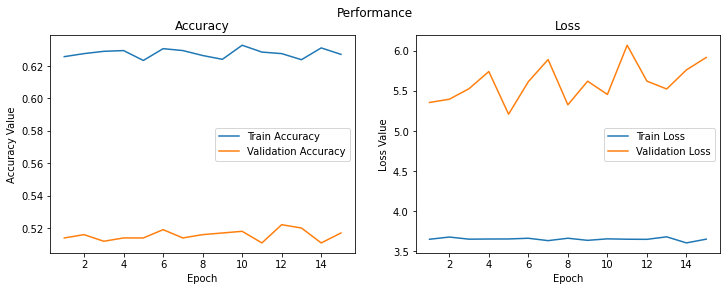

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Performance', fontsize=12)


epoch_list = list(range(1,epochs+1))
ax1.plot(epoch_list, torch.tensor(accuracies['train'], device = 'cpu'), label='Train Accuracy')
ax1.plot(epoch_list, torch.tensor(accuracies['val'], device = 'cpu'), label='Validation Accuracy')
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, losses['train'], label='Train Loss')
ax2.plot(epoch_list, losses['val'], label='Validation Loss')
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

# Model Evaluation on Test Set

In [29]:
testset = ImageFolder(PATH+'/test', 
                           transform=transforms.Compose([transforms.Resize((224,224)), 
                                                 transforms.ToTensor(),
                                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),                                                               
                                                 
                                                ]))

In [30]:
def distribution(data_set):
    #To calculate distribution of the datasets
    
    normal_path = os.path.join(path+f"/{data_set}/NORMAL")
    pneumonia_path = os.path.join(path+f"/{data_set}/PNEUMONIA")
  
    normal = len([filename for filename in os.listdir(normal_path)])
    pneumonia = len([filename for filename in os.listdir(pneumonia_path)])

    distribution = dict(zip(['Normal','Pneumonia'],[normal,pneumonia]))
    sns.barplot(x=list(distribution.keys()), y=list(distribution.values())).set_title(f"{data_set} Data Imbalance")
    return distribution

In [31]:
test_dl = DataLoader(testset, batch_size=256)
model.to(device);


In [32]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1) 
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)), preds

In [33]:
def validation(batch):
        images,labels = batch
        images,labels = images.to(device),labels.to(device)
        output = model(images)                                      
        loss = F.cross_entropy(output, labels)                    
        acc,predictions = accuracy(output, labels)                       
        
        return {'valid_loss': loss.detach(), 'valid_accuracy':acc.detach(), 'predictions':predictions.detach(), 'labels':labels.detach()}

In [34]:
@torch.no_grad()
def test_predict(model, test_dataloader):
    model.eval()
    
    outputs = [validation(batch) for batch in test_dataloader] 
    batch_losses = [x['valid_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()           
    batch_accs = [x['valid_accuracy'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()             
  
    batch_preds = [pred for x in outputs for pred in x['predictions'].tolist()] 
    batch_labels = [label for x in outputs for label in x['labels'].tolist()]  
    
    print('test_loss: {:.4f}, test_acc: {:.4f}'
          .format(epoch_loss.item(), epoch_acc.item()))
    
    return batch_preds, batch_labels

In [35]:
preds,labels = test_predict(model, test_dl)

test_loss: 0.2281, test_acc: 0.9353


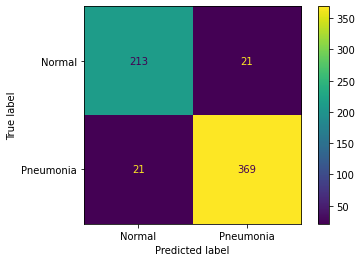

In [36]:
cm  = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Pneumonia'])
disp.plot()

In [37]:
print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       234
           1       0.95      0.95      0.95       390

    accuracy                           0.93       624
   macro avg       0.93      0.93      0.93       624
weighted avg       0.93      0.93      0.93       624



# Explaining the Predicitons

In [38]:
%pip install captum -q
import captum
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution, DeepLift, InputXGradient,LRP, LayerLRP,GuidedBackprop
from captum.attr import visualization as viz

import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Note: you may need to restart the kernel to use updated packages.


In [39]:
classes = dict({0: 'NORMAL',1: 'PNEUMONIA'})

In [40]:
MEAN = torch.tensor([0.485, 0.456, 0.406])
STD = torch.tensor([0.229, 0.224, 0.225])



def imshow(img, transpose = True):
    plt.figure(figsize = (11,6))
    x = img.cpu() * STD[:, None, None] + MEAN[:, None, None]
    #img = img / 2 + 0.5     # unnormalize
    npimg = x.cpu().numpy()
    plt.imshow(npimg.transpose(1, 2, 0))
    plt.axis('off')
    plt.show()
    

In [41]:
def pred_image(index):
    dataiter = iter(test_dl)
    images, labels = dataiter.next()
    images = images.to(device)
    labels = labels.to(device)
    ind = index
    input = images[ind].unsqueeze(0)
    input.requires_grad = True
    
    output = model(input)
    output = F.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)
    pred_label_idx.squeeze_()
    predicted_label = classes[pred_label_idx.item()]
    #imshow(images[ind])
    print('Index:',ind)
    print('Ground Truth:',classes[labels[ind].item()])
    print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')
    return input, pred_label_idx

## 1. Integrated Gradients

In [42]:
input,pred_label_idx = pred_image(0)

Index: 0
Ground Truth: NORMAL
Predicted: NORMAL ( 0.9999983310699463 )


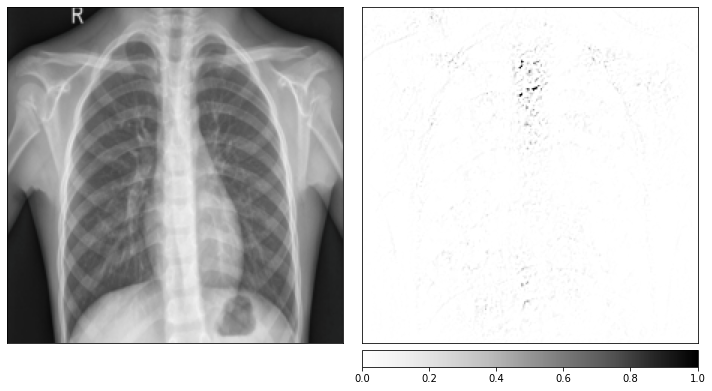

In [43]:
# Initialize the attribution algorithm with the model
integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=50)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose((input.cpu() * STD[:, None, None] + MEAN[:, None, None]).squeeze().detach().numpy(), (1,2,0)),
                                      ["original_image","heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                      fig_size=(10,8),
                                        cmap='Greys')

In [44]:
input,pred_label_idx = pred_image(255)

Index: 255
Ground Truth: PNEUMONIA
Predicted: PNEUMONIA ( 0.9973220229148865 )


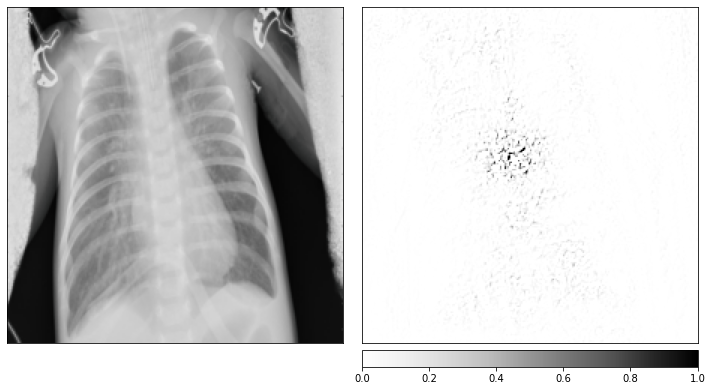

In [45]:
# Initialize the attribution algorithm with the model
integrated_gradients = IntegratedGradients(model)

attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=50)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose((input.cpu() * STD[:, None, None] + MEAN[:, None, None]).squeeze().detach().numpy(), (1,2,0)),
                                      ["original_image","heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                      fig_size=(10,8),
                                        cmap='Greys')

## 2. Input X Gradient

In [46]:
input,pred_label_idx = pred_image(0)

Index: 0
Ground Truth: NORMAL
Predicted: NORMAL ( 0.9999983310699463 )


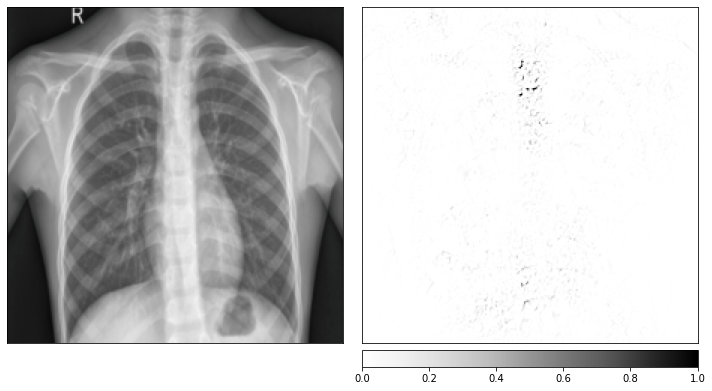

In [47]:
input_x_gradient = InputXGradient(model)
attribution_ixg = input_x_gradient.attribute(input, target=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attribution_ixg.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose((input.cpu() * STD[:, None, None] + MEAN[:, None, None]).squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image","heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                      fig_size=(10,8),
                                        cmap='Greys')

In [48]:
input,pred_label_idx = pred_image(255)


Index: 255
Ground Truth: PNEUMONIA
Predicted: PNEUMONIA ( 0.9973220229148865 )


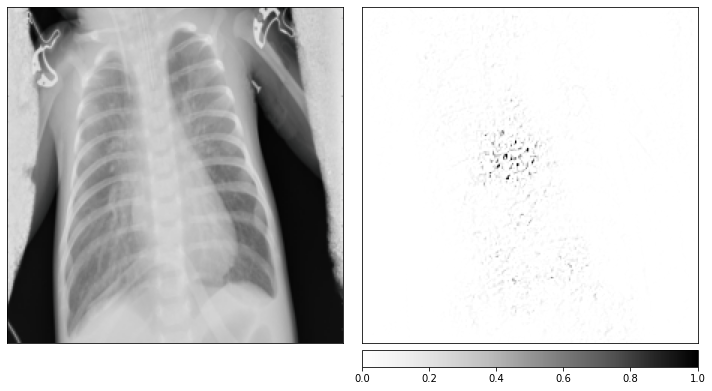

In [49]:
input_x_gradient = InputXGradient(model)
attribution_ixg = input_x_gradient.attribute(input, target=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attribution_ixg.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose((input.cpu() * STD[:, None, None] + MEAN[:, None, None]).squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image","heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                      fig_size=(10,8),
                                        cmap='Greys')

## 3. Occlusion

In [50]:
input,pred_label_idx = pred_image(0)

Index: 0
Ground Truth: NORMAL
Predicted: NORMAL ( 0.9999983310699463 )


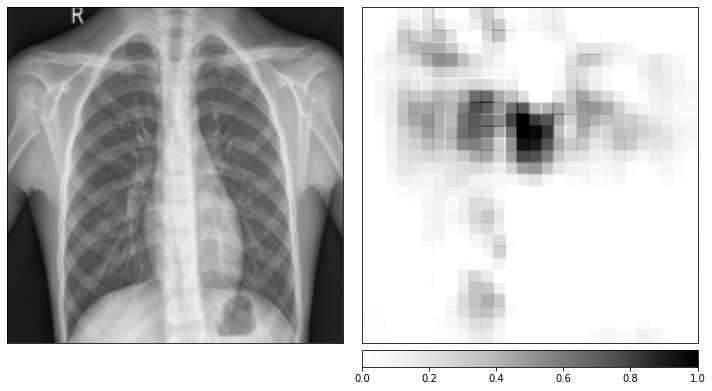

In [51]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       target=pred_label_idx,
                                       strides=(3, 8, 8),
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose((input.cpu() * STD[:, None, None] + MEAN[:, None, None]).squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image","heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                      fig_size=(10,8),
                                        cmap='Greys')

In [52]:
input,pred_label_idx = pred_image(255)

Index: 255
Ground Truth: PNEUMONIA
Predicted: PNEUMONIA ( 0.9973220229148865 )


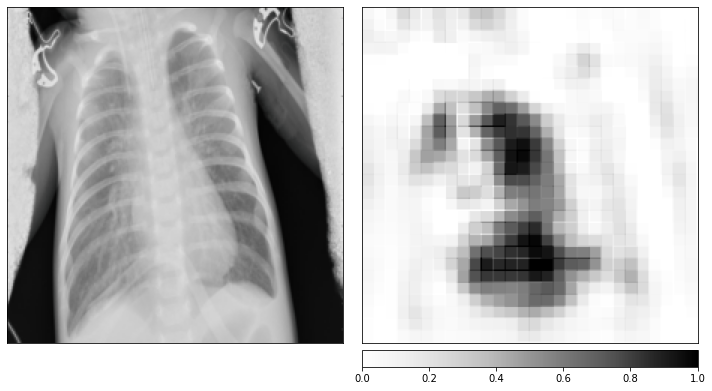

In [53]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       target=pred_label_idx,
                                       strides=(3, 8, 8),
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose((input.cpu() * STD[:, None, None] + MEAN[:, None, None]).squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image","heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                      fig_size=(10,8),
                                        cmap='Greys')

## 4. LRP- Layer-wise relevance propagation

In [59]:
input,pred_label_idx = pred_image(0)

Index: 0
Ground Truth: NORMAL
Predicted: NORMAL ( 0.9999983310699463 )


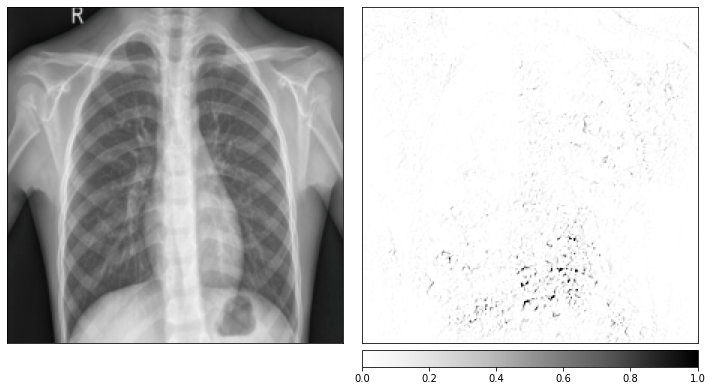

In [60]:
lrp = LRP(model)
attribution_lrp = lrp.attribute(input, target=pred_label_idx, verbose=False)

_ = viz.visualize_image_attr_multiple(np.transpose(attribution_lrp.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose((input.cpu() * STD[:, None, None] + MEAN[:, None, None]).squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image","heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                      fig_size=(10,8),
                                        cmap='Greys')

Index: 255
Ground Truth: PNEUMONIA
Predicted: PNEUMONIA ( 0.9973220229148865 )


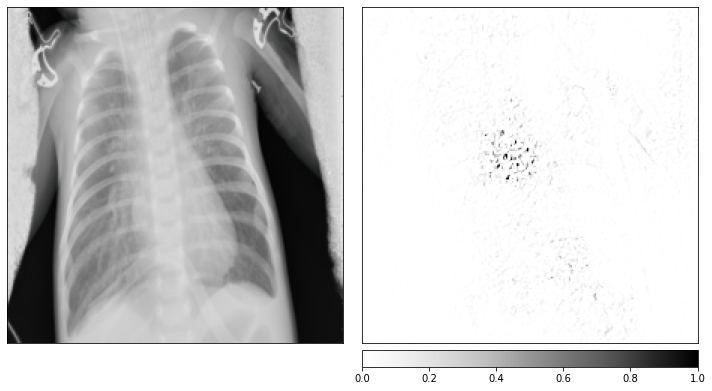

In [61]:
input,pred_label_idx = pred_image(255)

lrp = LRP(model)
attribution_lrp = lrp.attribute(input, target=0, verbose=False)

_ = viz.visualize_image_attr_multiple(np.transpose(attribution_lrp.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose((input.cpu() * STD[:, None, None] + MEAN[:, None, None]).squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image","heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                      fig_size=(10,8),
                                        cmap='Greys')